In [34]:
# Clasificación de Imágenes con Redes Neuronales

In [35]:
## 1. Importación de librerías
import tensorflow as tf
import tensorflow_datasets as tfds

In [36]:
## 2. Carga y preprocesamiento del dataset
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

In [37]:
metadatos

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

,image,label
0,,1 (dog)
1,,1 (dog)
2,,1 (dog)
3,,0 (cat)
4,,1 (dog)

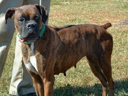
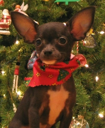
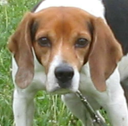
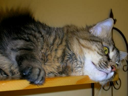
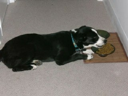

In [38]:
tfds.as_dataframe(datos['train'].take(5), metadatos)

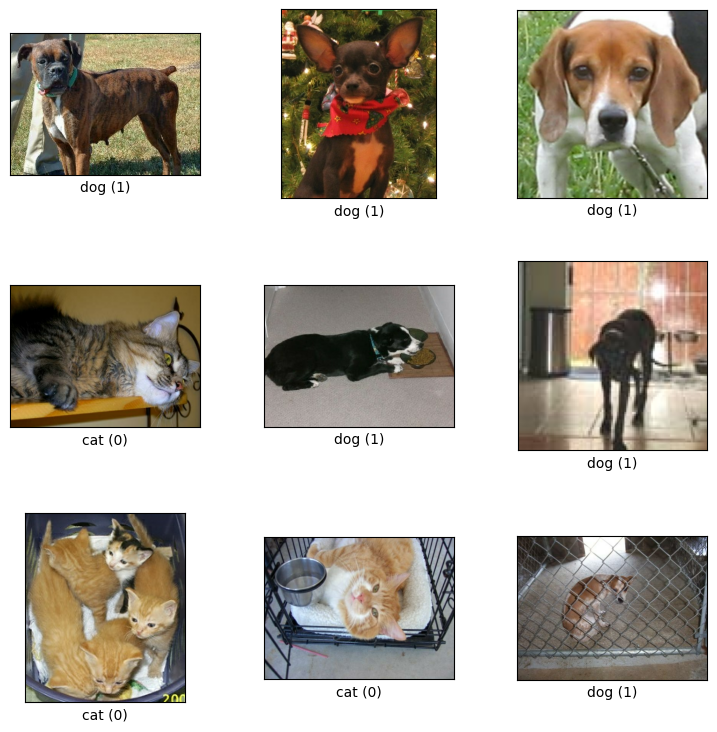

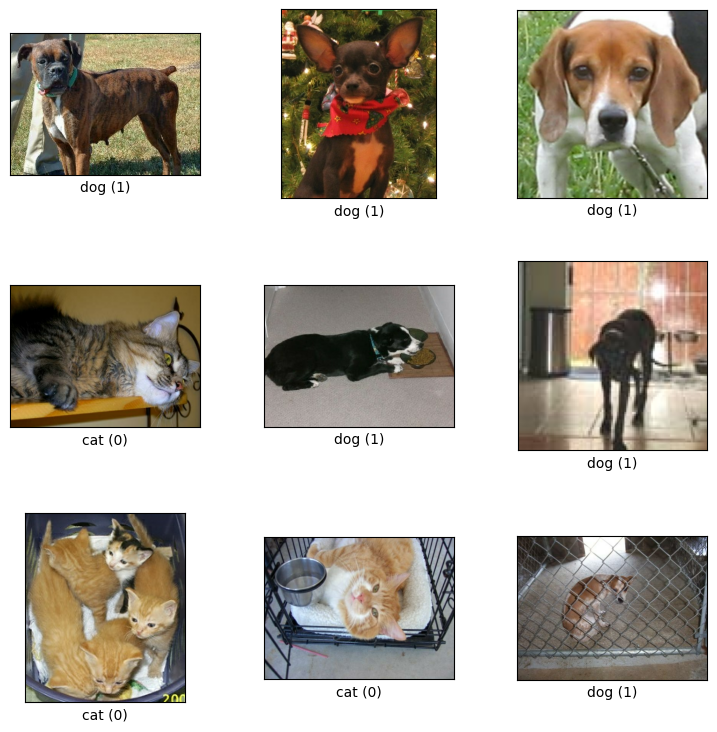

In [39]:
tfds.show_examples(datos['train'], metadatos)

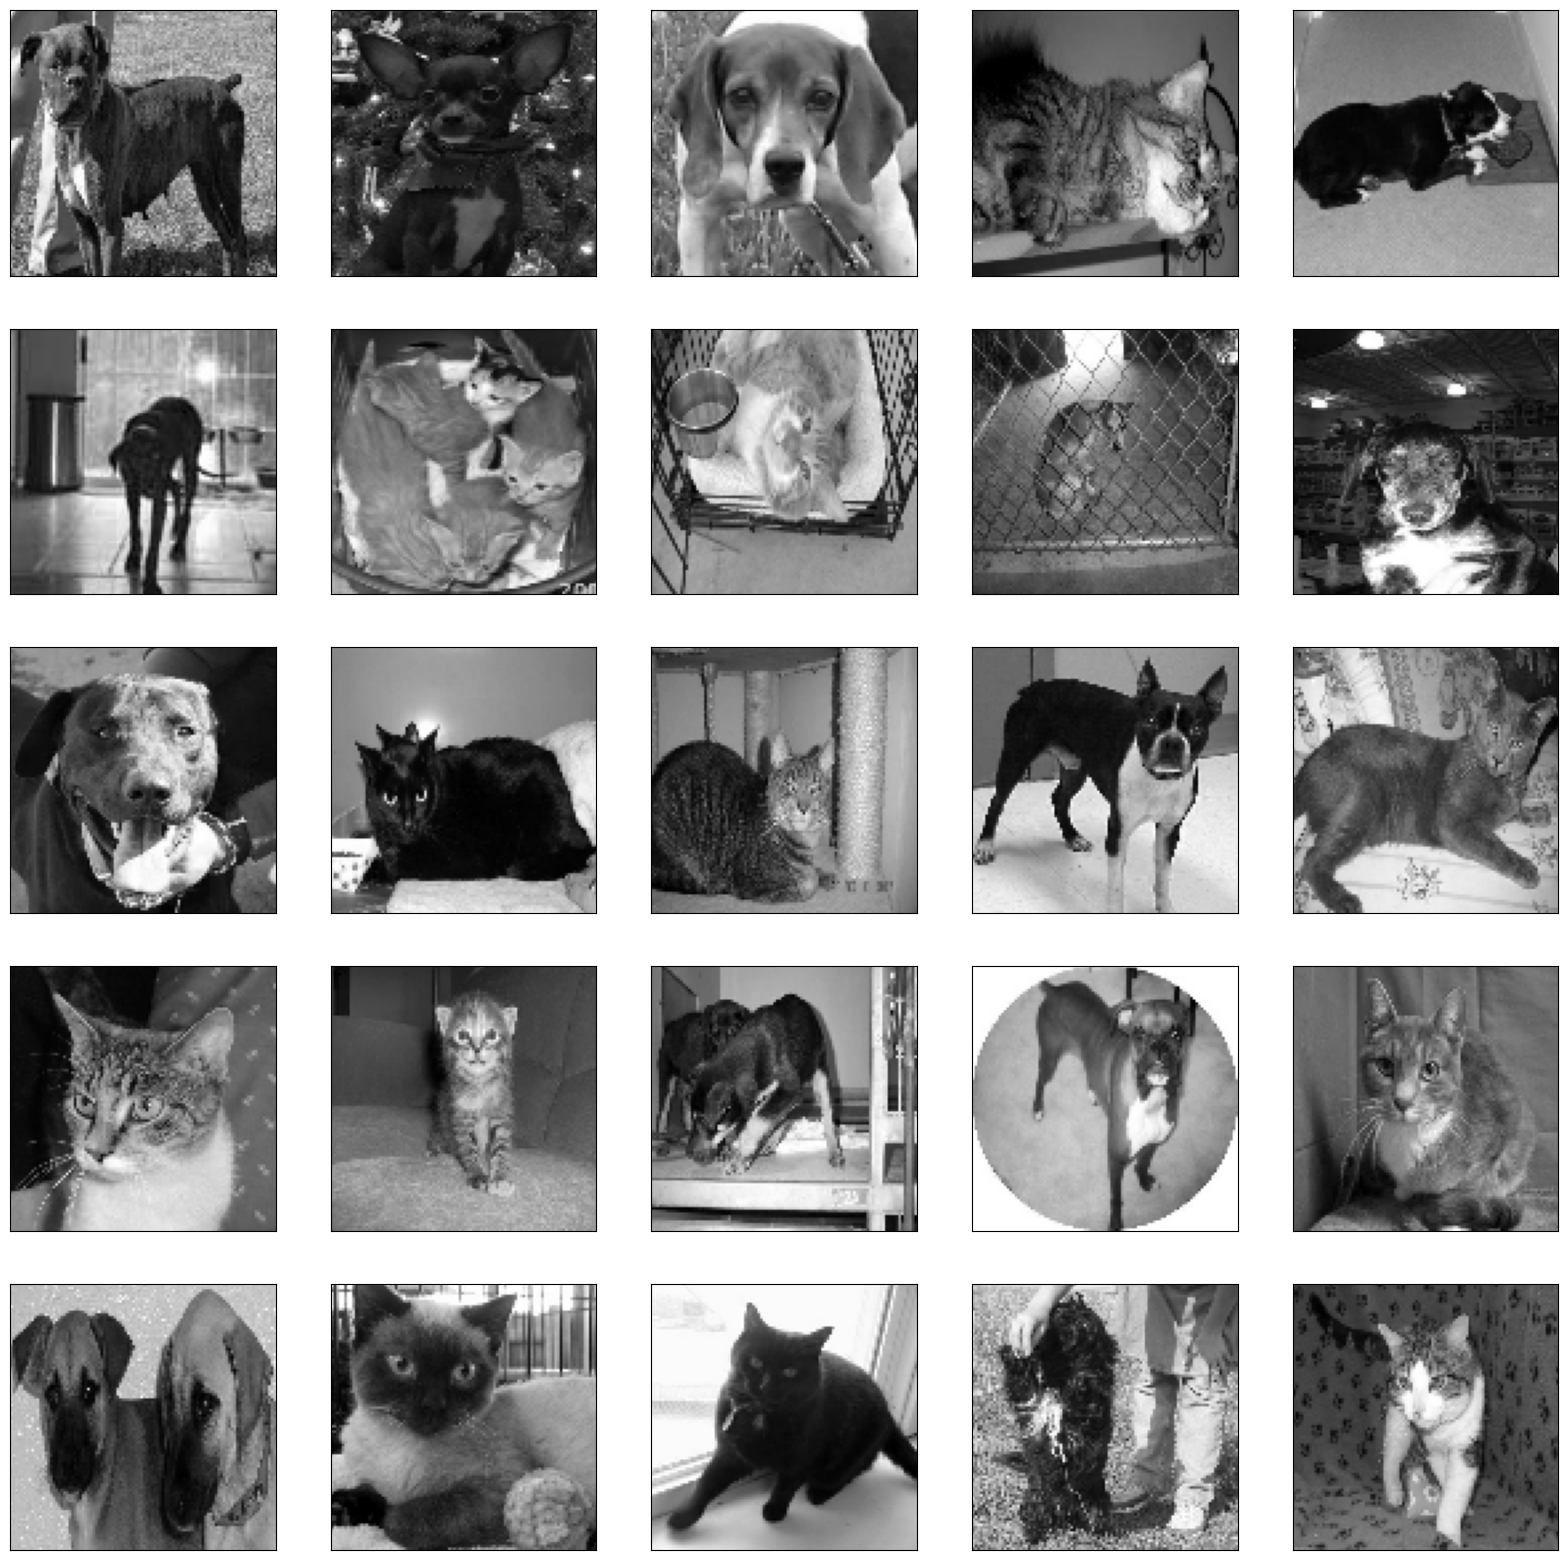

In [40]:
#Manipular y visualizar el set
#Lo pasamos a TAMANO_IMG (100x100) y a blanco y negro (solo para visualizar)
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20,20))

TAMANO_IMG=100

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray')

In [41]:
#Variable que contendra todos los pares de los datos (imagen y etiqueta) ya modificados (blanco y negro, 100x100)
datos_entrenamiento = []

In [42]:
for i, (imagen, etiqueta) in enumerate(datos['train']): #Todos los datos
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) #Cambiar tamano a 100,100,1
  datos_entrenamiento.append([imagen, etiqueta])

In [43]:
#Preparar mis variables X (entradas) y y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (perro o gato)

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [44]:
#Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255
import numpy as np

X = np.array(X).astype(float) / 255

In [45]:
#Convertir etiquetas en arreglo simple
y = np.array(y)

In [46]:
#Crear los modelos iniciales
#Sigmoid regresa siempre datos entre 0 y 1. Realizamos el entrenamiento para al final considerar que si la respuesta se
#acerca a 0, es un gato, y si se acerca a 1, es un perro.

## 3. Modelo Denso (Fully Connected)
modeloDenso = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

## 4. Modelo Convolucional (CNN)
modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
#Compilar modelos. Usar crossentropy binario ya que tenemos solo 2 opciones (perro o gato)
modeloDenso.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [48]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

Epoch 1/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5155 - loss: 0.8106 - val_accuracy: 0.5405 - val_loss: 0.6899
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5719 - loss: 0.6762 - val_accuracy: 0.5186 - val_loss: 0.7019
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5867 - loss: 0.6683 - val_accuracy: 0.6003 - val_loss: 0.6634
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6001 - loss: 0.6620 - val_accuracy: 0.5994 - val_loss: 0.6634
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6001 - loss: 0.6623 - val_accuracy: 0.5951 - val_loss: 0.6654
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.6623 - val_accuracy: 0.5884 - val_loss: 0.6727
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6063 - loss: 0.6596 - val_accuracy: 0.5710 - val_loss: 0.7052
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5997 - loss: 0.6607 - val_accuracy: 0.

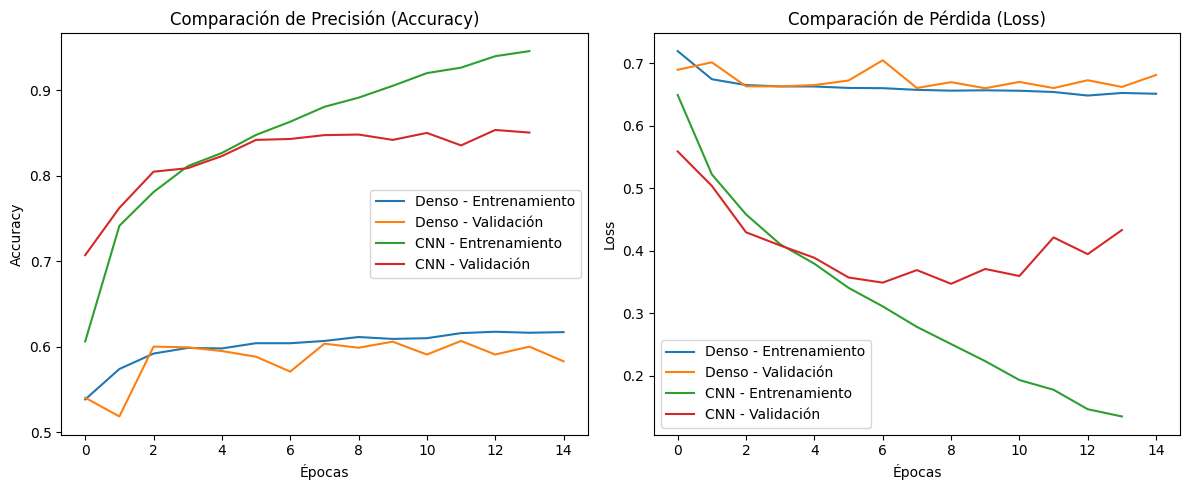

In [49]:
#Entrenamiento y comparación
import matplotlib.pyplot as plt

def plot_history(hist_denso, hist_cnn):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist_denso.history['accuracy'], label='Denso - Entrenamiento')
    plt.plot(hist_denso.history['val_accuracy'], label='Denso - Validación')
    plt.plot(hist_cnn.history['accuracy'], label='CNN - Entrenamiento')
    plt.plot(hist_cnn.history['val_accuracy'], label='CNN - Validación')
    plt.title('Comparación de Precisión (Accuracy)')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist_denso.history['loss'], label='Denso - Entrenamiento')
    plt.plot(hist_denso.history['val_loss'], label='Denso - Validación')
    plt.plot(hist_cnn.history['loss'], label='CNN - Entrenamiento')
    plt.plot(hist_cnn.history['val_loss'], label='CNN - Validación')
    plt.title('Comparación de Pérdida (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Guardá los resultados del entrenamiento al entrenar
hist_denso = modeloDenso.fit(X, y, epochs=20, validation_split=0.2, callbacks=[early_stopping])
hist_cnn = modeloCNN.fit(X, y, epochs=20, validation_split=0.2, callbacks=[early_stopping])

plot_history(hist_denso, hist_cnn)


727/727 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
727/727 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

=== Modelo Denso ===


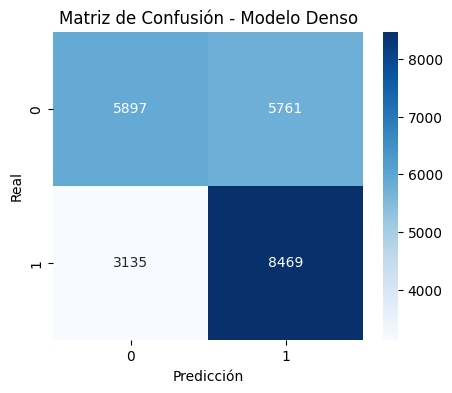


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.6529    0.5058    0.5700     11658
           1     0.5952    0.7298    0.6556     11604

    accuracy                         0.6176     23262
   macro avg     0.6240    0.6178    0.6128     23262
weighted avg     0.6241    0.6176    0.6127     23262


=== Modelo CNN ===


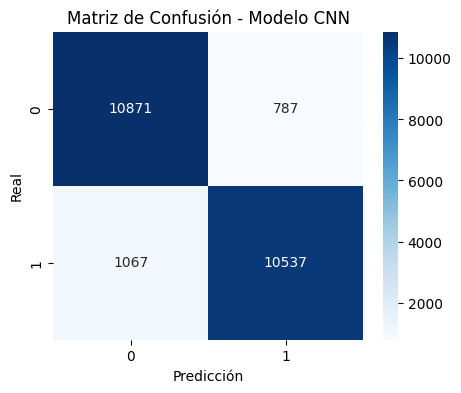


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9106    0.9325    0.9214     11658
           1     0.9305    0.9080    0.9191     11604

    accuracy                         0.9203     23262
   macro avg     0.9206    0.9203    0.9203     23262
weighted avg     0.9205    0.9203    0.9203     23262



In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predicciones
y_pred_denso = (modeloDenso.predict(X) > 0.5).astype(int)
y_pred_cnn = (modeloCNN.predict(X) > 0.5).astype(int)

# Función para graficar matriz y métricas
def evaluar_modelo(y_true, y_pred, nombre):
    print(f'\n=== {nombre} ===')
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    print('\nReporte de Clasificación:')
    print(classification_report(y_true, y_pred, digits=4))

# Evaluación de ambos modelos
evaluar_modelo(y, y_pred_denso, "Modelo Denso")
evaluar_modelo(y, y_pred_cnn, "Modelo CNN")


## Conclusiones: Comparativa entre el modelo Denso y el modelo Convolucional

Tras comparar ambos modelos con el mismo conjunto de datos (Cats vs Dogs, `tensorflow_datasets`), se obtuvieron los siguientes resultados:

- El **modelo denso** logra una precisión promedio cercana al **60%**, mostrando que las capas totalmente conectadas, sin extracción de características espaciales, no logran capturar adecuadamente las diferencias entre perros y gatos en imágenes en escala de grises.
- El **modelo convolucional (CNN)** alcanza una precisión de validación en torno al **85% - 87%**, con una clara reducción en la función de pérdida.  
  Esto se debe a su capacidad para detectar patrones locales (bordes, texturas, formas) mediante filtros y capas de pooling, lo que mejora significativamente la generalización.

### 🔍 Análisis técnico

- El modelo denso trata cada píxel como una característica independiente, ignorando la estructura espacial de la imagen.
- La CNN aprovecha la **invarianza traslacional**, extrayendo características jerárquicas que permiten distinguir correctamente las formas y contornos propios de perros y gatos.
- Se utilizó **Early Stopping** para evitar sobreajuste, deteniendo el entrenamiento cuando la pérdida de validación dejó de mejorar.

### 📈 Conclusión final

La comparación evidencia que:
> **Las redes convolucionales (CNN)** son mucho más adecuadas para tareas de clasificación de imágenes que los modelos densos tradicionales.

El trabajo demuestra, de forma práctica, cómo el uso de arquitecturas adaptadas al tipo de dato (en este caso, imágenes) impacta directamente en la performance del modelo.

---


📚 **Autor:** Agustín Gioia  
🔗 **Proyecto:** Clasificación de Imágenes con Redes Neuronales — Comparativa entre MLP y CNN  
🧩 **Frameworks:** TensorFlow, Keras, OpenCV, Scikit-Learn